In [123]:
import sys
sys.path.append("..")

In [177]:
import ast
import time
import pandas as pd
import numpy as np

import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

import gensim
import torchtext
from torchtext import data
from torchtext import vocab

import matplotlib.pyplot as plt
import seaborn as sns

from utils.db_client import DBClient

In [125]:
# Make DB Connection
db = DBClient(secrets_path='../configs/db_secrets.json')

I'm trying
Connected to political tweets DB


### Model definition and tuning

In [126]:
# Load data
examples = db.read("select tweet_text_clean, label from staging.train_twitter140 order by Random() limit 100000")

In [127]:
# Define Fields
txt_field = data.Field(sequential=True, 
                       include_lengths=True, 
                       use_vocab=True)
label_field = data.Field(sequential=False, 
                         use_vocab=False, 
                         pad_token=None, 
                         unk_token=None)
train_val_fields = [
    ('SentimentText', txt_field), # process it as text
    ('Sentiment', label_field) # process it as label
]

# Convert text ecamples to Example datatype
examples = [data.Example.fromlist(((ast.literal_eval(example[0])), example[1]), train_val_fields) for example in examples]

# Create dataset
dataset = data.Dataset(examples, train_val_fields)

In [85]:
txt_field.vocab.itos

['<unk>',
 '<pad>',
 'im',
 'get',
 'go',
 'day',
 'good',
 'work',
 'like',
 'love',
 'dont',
 'today',
 'time',
 'cant',
 'think',
 'know',
 'back',
 'want',
 'make',
 'see',
 'well',
 'miss',
 'one',
 'lol',
 'really',
 'feel',
 'need',
 'come',
 'night',
 'still',
 'new',
 'watch',
 'look',
 'home',
 'thanks',
 'oh',
 'much',
 'last',
 'morning',
 'hope',
 'say',
 'great',
 'twitter',
 'sleep',
 'tomorrow',
 'take',
 'wait',
 'wish',
 'ill',
 'bad',
 'thats',
 'haha',
 'sad',
 'try',
 'fun',
 'right',
 'didnt',
 'week',
 'thing',
 'happy',
 'would',
 'sorry',
 'way',
 'friend',
 'tonight',
 'find',
 'gonna',
 'nice',
 'leave',
 'though',
 'ive',
 'bed',
 'could',
 'start',
 'tweet',
 'youre',
 'people',
 'hour',
 'show',
 'hate',
 'yeah',
 'school',
 'guy',
 'weekend',
 'yes',
 'play',
 'hey',
 'even',
 'never',
 'let',
 'next',
 'thank',
 'follow',
 'awesome',
 'long',
 'use',
 'soon',
 'little',
 'best',
 'eat',
 'everyone',
 'tell',
 'wanna',
 'keep',
 'movie',
 'ok',
 'first',


In [128]:
MAX_VOCAB_SIZE = 25000

# Make vocab for text and label fields
txt_field.build_vocab(dataset,
                      max_size = MAX_VOCAB_SIZE, 
                      vectors = vocab.Vectors('glove.twitter.27B.50d.txt', '../model/glove.twitter.27B/'))
label_field.build_vocab(dataset)

pretrained_embeddings = txt_field.vocab.vectors

# Make train/val/test splits
train_data, test_data, valid_data = dataset.split([0.7, 0.2, 0.1])

In [129]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 70000
Number of validation examples: 20000
Number of testing examples: 10000


In [130]:
len(train_data.examples)

70000

In [131]:
# Make data iterators
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test_data), 
                                                          batch_sizes = (BATCH_SIZE, BATCH_SIZE, BATCH_SIZE),
                                                                        sort_key = lambda x: len(x.SentimentText),
                                                                        sort_within_batch=True,
                                                                        repeat = False)

In [158]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, pad_idx):#, optimizer, criterion):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.embedding_dim = embedding_dim
        self.pad_idx = pad_idx
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           #bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.optimizer = None #optimizer #optim.Adam(model.parameters())
        self.criterion = None #criterion #nn.BCEWithLogitsLoss()
        
    
    def set_pretrained_weights(self, pretrained_embeddings, txt_field):
        self.embedding.weight.data.copy_(pretrained_embeddings)

        UNK_IDX = txt_field.vocab.stoi[txt_field.unk_token]

        self.embedding.weight.data[UNK_IDX] = torch.zeros(self.embedding_dim)
        self.embedding.weight.data[self.pad_idx] = torch.zeros(self.embedding_dim)
    
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))
    
    def binary_accuracy(self, preds, y):
        """
        Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
        """

        #round predictions to the closest integer
        rounded_preds = torch.round(torch.sigmoid(preds))
        correct = (rounded_preds == y).float() #convert into float for division 
        acc = correct.sum() / len(correct)
        return acc
    
    def train_epoch(self, iterator):
        epoch_loss = 0
        epoch_acc = 0

        self.train()
        optimizer = self.optimizer
        for batch in iterator:
            if len(batch) == BATCH_SIZE:
            
                optimizer.zero_grad()

                text, text_lengths = batch.SentimentText
                predictions = self.forward(text, text_lengths).squeeze(1)
                loss = self.criterion(predictions, batch.Sentiment.float())

                acc = self.binary_accuracy(predictions, batch.Sentiment.float())

                loss.backward()

                optimizer.step()

                epoch_loss += loss.item()
                epoch_acc += acc.item()

        return epoch_loss / len(iterator), epoch_acc / len(iterator)

    def evaluate(self, iterator):

        epoch_loss = 0
        epoch_acc = 0

        model.eval()

        with torch.no_grad():

            for batch in iterator:
                if len(batch) == BATCH_SIZE:

                    text, text_lengths = batch.SentimentText

                    predictions = self.forward(text, text_lengths).squeeze(1)

                    loss = self.criterion(predictions, batch.Sentiment.float())

                    acc = self.binary_accuracy(predictions, batch.Sentiment.float())

                    epoch_loss += loss.item()
                    epoch_acc += acc.item()

        return epoch_loss / len(iterator), epoch_acc / len(iterator)
    
    def sentiment_political(self, iterator):
        # keep?
        #model.eval()
        
        sentiment_df = None

        with torch.no_grad():
            batch_no = 0

            for batch in iterator:
                if len(batch) == BATCH_SIZE:

                    text, text_lengths = batch.SentimentText

                    predictions = self.forward(text, text_lengths).squeeze(1)
                    
                    preds = torch.sigmoid(predictions)
                    
                    pred_arr = preds.numpy()
                    id_arr = batch.Id.numpy()
                    pred_class_arr = torch.round(preds).numpy()
                    
                    if batch_no == 0:
                        sentiment_df = pd.DataFrame({"tweet_id": id_arr, 
                                                     "prediction_raw": pred_arr, 
                                                     "prediction_class": pred_class_arr})
                    else:
                        sentiment_df = pd.concat([sentiment_df, pd.DataFrame({"tweet_id": id_arr, 
                                                     "prediction_raw": pred_arr, 
                                                     "prediction_class": pred_class_arr})])
                    batch_no += 1
            

                    #loss = self.criterion(predictions, batch.Sentiment.float())

                    #acc = self.binary_accuracy(predictions, batch.Sentiment.float())

                    #epoch_loss += loss.item()
                    #epoch_acc += acc.item()
        return sentiment_df
    
    def epoch_time(self, start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs

In [133]:
def epoch_training(N_EPOCHS, model, train_iterator, valid_iterator):
    best_valid_loss = float('inf')

    for epoch in range(N_EPOCHS):

        start_time = time.time()

        train_loss, train_acc = model.train_epoch(train_iterator)
        valid_loss, valid_acc = model.evaluate(valid_iterator)

        end_time = time.time()

        epoch_mins, epoch_secs = model.epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'tut2-model.pt')

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        
    return model

In [134]:
optimizers = ["Adam"]
criterions = ["BCEWithLogitsLoss"] 
learning_rates = [0.001]
epochs = [5] 
weight_decay = [0]

In [ ]:
INPUT_DIM = len(txt_field.vocab)
EMBEDDING_DIM = 50
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
DROPOUT = 0.5
PAD_IDX = txt_field.vocab.stoi[txt_field.pad_token]


best_model_tuple = None
best_accuracy = -1
for optimizer in optimizers:
    # Make a new model at the start
    model = LSTM(INPUT_DIM, 
                EMBEDDING_DIM, 
                HIDDEN_DIM, 
                OUTPUT_DIM, 
                N_LAYERS,
                DROPOUT, 
                PAD_IDX)
    model.set_pretrained_weights(pretrained_embeddings, txt_field)
    for learning_rate in learning_rates:
        for decay in weight_decay:
            # Set OPTIMIZER
            if optimizer == "Adam":
                model.optimizer = optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay = decay) 
            else: 
                model.optimizer = optim.Adagrad(params = model.parameters(), lr = learning_rate, weight_decay = decay)

            for criterion in criterions:
                # SET CRITERION
                if criterion == "BCEWithLogitsLoss":
                    model.criterion = nn.BCEWithLogitsLoss() 
                else: 
                    model.criterion = nn.NLLLoss()
                
                for epoch in epochs:
                    model_name = "-".join([optimizer, str(learning_rate), str(decay), str(criterion), str(epoch)])

                    print(f"working on model {model_name}")
                    trained_model = epoch_training(epoch, model, train_iterator, valid_iterator)
                    _, acc = trained_model.evaluate(valid_iterator)
                    
                    if acc > best_accuracy:
                        best_accuracy = acc
                        best_model_tuple = (model_name, trained_model)


In [137]:
best_model_name = best_model_tuple[0]
best_model = best_model_tuple[1]

In [138]:
print(best_model_name)
best_model.evaluate(test_iterator)

Adam-0.001-0-BCEWithLogitsLoss-5


(0.4839125668546956, 0.7624402866242038)

In [139]:
run_no = "final"
torch.save(best_model.state_dict(), 'models_store/best_model_dict_{}_{}.pt'.format(best_model_name, run_no))
torch.save(best_model, 'models_store/best_model_{}_{}.pt'.format(best_model_name, run_no))


/Users/alenastern/.virtualenvs/aml/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Subject Analysis

In [162]:
# Load data
num_tweets = 100000
topics = ['health', 'econ_jobs', 'immigration', 'taxes']
topics_str = ', '.join(topics)
query_start = "select tweet_text_clean, tweet_id, tweet_text_raw, leadership, democrat, {} from staging.master WHERE ".format(topics_str)
for topic in topics: 
    query_start += "{}::int = 1 OR ".format(topic)
query_start = query_start[:-3]


query = query_start
print(query)
db.conn.rollback()
examples_db = db.read(query)



select tweet_text_clean, tweet_id, tweet_text_raw, leadership, democrat, health, econ_jobs, immigration, taxes from staging.master WHERE health::int = 1 OR econ_jobs::int = 1 OR immigration::int = 1 OR taxes::int = 1 


In [163]:
examples_train = [(example[0], example[1]) for example in examples_db]

In [164]:
examples_train[0]

("['west', 'coast', 'attempt', 'literally', 'limit', 'first', 'amendment', 'punish', 'business', 'create', 'job', 'idolized', 'worship', 'pornstar', 'reason', 'try', 'make', 'trump', 'look', 'bad', 'thank', 'god', 'im', 'safe', 'side', 'country']",
 '1000005833374265344')

In [165]:
# Define Fields
txt_field_eval = data.Field(sequential=True, 
                       include_lengths=True, 
                       use_vocab=True)

txt_field_eval.vocab = txt_field.vocab
id_field_eval = data.Field(sequential=False, 
                      use_vocab=False, 
                      pad_token=None, 
                      unk_token=None)

eval_val_fields = [
    ('SentimentText', txt_field_eval), # process it as text
    ('Id', id_field_eval) # process it as id
]


# Convert text examples to Example datatype
examples = [data.Example.fromlist(((ast.literal_eval(example[0])), example[1]), eval_val_fields) for example in examples_train]

# Create dataset
dataset = data.Dataset(examples, eval_val_fields)


In [101]:
vocab_dict = txt_field.vocab.stoi
for example in dataset.examples:
    for token in example.SentimentText:

SyntaxError: unexpected EOF while parsing (<ipython-input-101-d85b6a53b5b9>, line 3)

In [142]:
txt_field_eval.vocab.vectors

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1259,  0.7006,  0.1237,  ...,  0.2219, -0.7194,  0.7646],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2846,  1.2260, -0.9739,  ..., -0.1293, -0.4296, -0.3433]])

In [ ]:
test_example = examples[0]
test_example.SentimentText

In [166]:
# Create Iterator
BATCH_SIZE = 64
# train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test_data), 
#                                                           batch_sizes = (BATCH_SIZE, BATCH_SIZE, BATCH_SIZE),
#                                                                         sort_key = lambda x: len(x.SentimentText),
#                                                                         sort_within_batch=True,
#                                                                         repeat = False)


# train, test = dataset.split([0.5, 0.5])
# eval_iterator = data.BucketIterator.splits((train, test), 
#                                            batch_sizes = (BATCH_SIZE, BATCH_SIZE), 
#                                            sort_key = lambda x: len(x.SentimentText),
#                                            sort_within_batch=True,
#                                            repeat = False)


eval_iterator = data.BucketIterator(dataset, 
                                           batch_size = BATCH_SIZE, 
                                           sort_key = lambda x: len(x.SentimentText),
                                           sort_within_batch=True,
                                           repeat = False)

In [111]:
for batch in eval_iterator:
    print(len(batch))

64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
6

In [121]:
# load best model
final_model = torch.load('models_store/best_model_Adam-0.001-0-BCEWithLogitsLoss-5_1.pt')
final_model.eval()

LSTM(
  (embedding): Embedding(25002, 50, padding_idx=1)
  (rnn): LSTM(50, 256, num_layers=2, dropout=0.5)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5)
  (criterion): BCEWithLogitsLoss()
)

In [167]:
# Calculate sentiment of each tweet
sentiment_df = best_model.sentiment_political(eval_iterator)
sentiment_df.to_csv('models_store/political_sentiment_{}_{}.csv'.format(best_model_name, run_no))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [168]:
sentiment_df.groupby('prediction_class').size()

prediction_class
0.0    37702
1.0    26746
dtype: int64

In [173]:
sentiment_df['tweet_id'] = pd.to_numeric(sentiment_df['tweet_id'])
sentiment_df.head()


,tweet_id,prediction_raw,prediction_class
0,887831325113278466,0.666367,1.0
1,1027215357826584576,0.355783,0.0
2,677572636344516608,0.526792,1.0
3,32586949248155648,0.518794,1.0
4,1058366556051128320,0.176461,0.0


In [190]:
data_full = pd.DataFrame(examples_db, columns = ['tweet_text_clean', 'tweet_id', 
                                            'tweet_text_raw', 'leadership', 'democrat'] + topics )

In [192]:
data_full['tweet_id'] = pd.to_numeric(data_full['tweet_id'])
data_full.head()

,tweet_text_clean,tweet_id,tweet_text_raw,leadership,democrat,health,econ_jobs,immigration,taxes
0,"['west', 'coast', 'attempt', 'literally', 'lim...",1000005833374265344,So the west coast has now attempted to literal...,False,True,False,True,False,False
1,"['democrat', 'foreign', 'invader', 'godgiven',...",1000007055065911296,Democrats are foreign invaders on our God-give...,False,True,False,True,False,False
2,"['help', 'im', 'try', 'find', 'plan', 'make', ...",1000007673193140225,HELP! I'm trying to find @RepTrey's plan for m...,True,True,True,False,False,False
3,"['bring', 'cost', 'health', 'care', 'cover', '...",1000007675684507650,"We CAN bring down the costs of health care, an...",True,True,True,False,False,False
4,"['good', 'job', 'gop', 'harm', 'worker']",1000008098684252161,Good job by @SpeakerRyan @SenateMajLdr &amp; t...,False,False,False,True,False,False


### Plotting Results

In [193]:
pol_data = data_full.merge(sentiment_df, on = 'tweet_id')
pol_data['negative'] = np.where((pol_data['prediction_class'] == 0), 1, 0)
pol_data['positive'] = np.where((pol_data['prediction_class'] == 1), 1, 0)
pol_data.head()

,tweet_text_clean,tweet_id,tweet_text_raw,leadership,democrat,health,econ_jobs,immigration,taxes,prediction_raw,prediction_class,negative,positive
0,"['west', 'coast', 'attempt', 'literally', 'lim...",1000005833374265344,So the west coast has now attempted to literal...,False,True,False,True,False,False,0.418391,0.0,1,0
1,"['democrat', 'foreign', 'invader', 'godgiven',...",1000007055065911296,Democrats are foreign invaders on our God-give...,False,True,False,True,False,False,0.171387,0.0,1,0
2,"['help', 'im', 'try', 'find', 'plan', 'make', ...",1000007673193140225,HELP! I'm trying to find @RepTrey's plan for m...,True,True,True,False,False,False,0.600075,1.0,0,1
3,"['bring', 'cost', 'health', 'care', 'cover', '...",1000007675684507650,"We CAN bring down the costs of health care, an...",True,True,True,False,False,False,0.533935,1.0,0,1
4,"['good', 'job', 'gop', 'harm', 'worker']",1000008098684252161,Good job by @SpeakerRyan @SenateMajLdr &amp; t...,False,False,False,True,False,False,0.495701,0.0,1,0


In [187]:
pol_data.to_csv('pol_data.csv')

In [188]:
choices = ['dem-lead', 'dem-base', 'rep-lead', 'rep-base']
palette = {"dem-base": "#a8b2ff","dem-lead": "#0015bc", "rep-base": "#ff9d9d", "rep-lead": "#ff0000", "": "gray"}


In [194]:
def results_for_plotting(df):
    df['group'] = np.where((df['democrat']==True) & (df['leadership']==True), 'dem-lead', 
        np.where((df['democrat']==True) & (df['leadership']==False), 'dem-base',
        np.where((df['democrat']==False) & (df['leadership']==True), 'rep-lead', 
        np.where((df['democrat']==False) & (df['leadership']==False), 'rep-base', ""))))

    plotting = pd.melt(df[df['group'] != ""], id_vars = ['democrat', 'leadership', 'group', 'tweet_id', 'tweet_text_raw', 'tweet_text_clean', 'prediction_class', 'prediction_raw'])

    return plotting
    
    

In [226]:
def plot(plotting, palette, topic, neg_pos_only = True):
    if neg_pos_only:
        data = plotting[plotting['variable'].isin(['negative', 'positive'])]
    else:
        data = plotting
    plt.figure(figsize = (6, 3.5))
    sns_plot = sns.barplot(x='variable', y='value', hue='group', data=data, palette=palette)
   #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sns_plot.figure.savefig("plots/{}.png".format(topic))

/Users/alenastern/.virtualenvs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


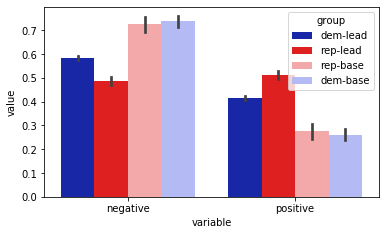

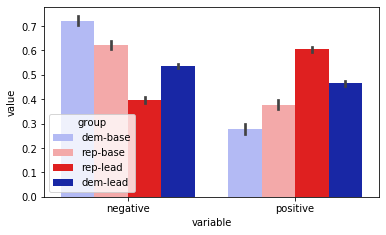

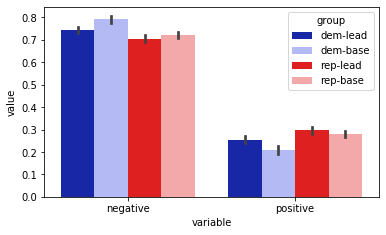

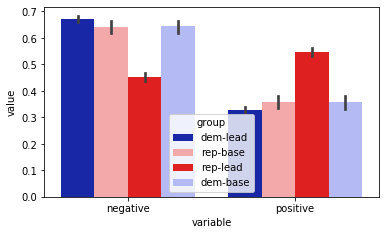

In [227]:
for topic in topics:
    topic_data = pol_data[pol_data[topic] == True]
    topic_data.drop(topics, axis=1, inplace=True)
    topic_data_plot = results_for_plotting(topic_data)
    plot(topic_data_plot, palette, topic)
    

In [198]:

health_data.head()

,tweet_text_clean,tweet_id,tweet_text_raw,leadership,democrat,prediction_raw,prediction_class,negative,positive
2,"['help', 'im', 'try', 'find', 'plan', 'make', ...",1000007673193140225,HELP! I'm trying to find @RepTrey's plan for m...,True,True,0.600075,1.0,0,1
3,"['bring', 'cost', 'health', 'care', 'cover', '...",1000007675684507650,"We CAN bring down the costs of health care, an...",True,True,0.533935,1.0,0,1
6,"['youre', 'right', 'cant', 'win', 'fight', 'us...",1000013643201896451,"@rachbarnhart You’re right, @rachbarnhart, we ...",True,None,0.438427,0.0,1,0
8,"['insurance', 'premium', 'go', 'deliberate', '...",1000013711153815552,Why are insurance premiums going up? Because o...,True,True,0.585708,1.0,0,1
11,"['crucial', 'open', 'conversation', 'mental', ...",1000023181296533505,It's crucial to have open conversations about ...,True,True,0.453225,0.0,1,0


/Users/alenastern/.virtualenvs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [200]:
health_data_plot.head()

,democrat,leadership,group,tweet_id,tweet_text_raw,tweet_text_clean,prediction_class,prediction_raw,variable,value
0,True,True,dem-lead,1000007673193140225,HELP! I'm trying to find @RepTrey's plan for m...,"['help', 'im', 'try', 'find', 'plan', 'make', ...",1.0,0.600075,negative,0
1,True,True,dem-lead,1000007675684507650,"We CAN bring down the costs of health care, an...","['bring', 'cost', 'health', 'care', 'cover', '...",1.0,0.533935,negative,0
2,True,True,dem-lead,1000013711153815552,Why are insurance premiums going up? Because o...,"['insurance', 'premium', 'go', 'deliberate', '...",1.0,0.585708,negative,0
3,True,True,dem-lead,1000023181296533505,It's crucial to have open conversations about ...,"['crucial', 'open', 'conversation', 'mental', ...",0.0,0.453225,negative,1
4,False,True,rep-lead,1000044459105640448,Heroin &amp; opioid abuse are devastating fami...,"['heroin', 'opioid', 'abuse', 'devastate', 'fa...",0.0,0.061873,negative,1


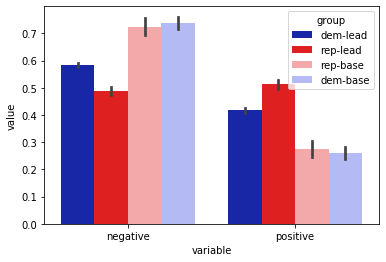

In [208]:
plot(health_data_plot, palette)

In [ ]:
# def train(model, iterator):
    
#     epoch_loss = 0
#     epoch_acc = 0
    
#     model.train()
    
#     for batch in iterator:
        
#         optimizer.zero_grad()
        
#         text, text_lengths = batch.SentimentText
        
#         predictions = model(text, text_lengths).squeeze(1)

#         loss = model.criterion(predictions, batch.Sentiment.float())
        
#         acc = binary_accuracy(predictions, batch.Sentiment.float())
        
#         loss.backward()
        
#         model.optimizer.step()
        
#         epoch_loss += loss.item()
#         epoch_acc += acc.item()
        
#     return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
# def evaluate(model, iterator):
    
#     epoch_loss = 0
#     epoch_acc = 0
    
#     model.eval()
    
#     with torch.no_grad():
    
#         for batch in iterator:
            
#             text, text_lengths = batch.SentimentText

#             predictions = model(text, text_lengths).squeeze(1)
            
#             loss = model.criterion(predictions, batch.Sentiment.float())
            
#             acc = binary_accuracy(predictions, batch.Sentiment.float())

#             epoch_loss += loss.item()
#             epoch_acc += acc.item()
        
#     return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [ ]:
# def epoch_time(start_time, end_time):
#     elapsed_time = end_time - start_time
#     elapsed_mins = int(elapsed_time / 60)
#     elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
#     return elapsed_mins, elapsed_secs

In [ ]:
# INPUT_DIM = len(txt_field.vocab)
# EMBEDDING_DIM = 50
# HIDDEN_DIM = 256
# OUTPUT_DIM = 1
# N_LAYERS = 2
# DROPOUT = 0.5
# PAD_IDX = txt_field.vocab.stoi[txt_field.pad_token]
# OPTIMIZER = optim.Adam(model.parameters())
# CRITERION = nn.BCEWithLogitsLoss()

# model = LSTM(INPUT_DIM, 
#             EMBEDDING_DIM, 
#             HIDDEN_DIM, 
#             OUTPUT_DIM, 
#             N_LAYERS,
#             DROPOUT, 
#             PAD_IDX,
#             OPTIMIZER,
#             CRITERION)

In [ ]:
trained_model = epoch_training(10, model, train_iterator, valid_iterator)

In [ ]:
#OPTIMIZER = optim.Adam(model.parameters())
#CRITERION = nn.BCEWithLogitsLoss()

# model = LSTM(INPUT_DIM, 
#             EMBEDDING_DIM, 
#             HIDDEN_DIM, 
#             OUTPUT_DIM, 
#             N_LAYERS,
#             DROPOUT, 
#             PAD_IDX,
#             OPTIMIZER,
#             CRITERION)

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

NameError: name 'model' is not defined